In [1]:
import shutup
import time
import tskit
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import torch
from torch_geometric.loader import DataLoader
import torch_geometric.transforms as T
from tsgcn.simulation import MsprimeSimulation, run_sims
from tsgcn.util import get_idle_gpu, get_degree_histogram
from tsgcn.data import TreeSequenceData, TreeSequencesDataset, windowed_div_from_ts, compute_ys, get_node_features
from tsgcn.model import GNNNet
from tsgcn.optimization import train, test

shutup.please()

/home/murillor/miniconda3/envs/gcn/lib/python3.10/site-packages/torch_geometric/typing.py:31: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /home/murillor/miniconda3/envs/gcn/lib/python3.10/site-packages/torch_scatter/_version_cpu.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/home/murillor/miniconda3/envs/gcn/lib/python3.10/site-packages/torch_geometric/typing.py:42: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /home/murillor/miniconda3/envs/gcn/lib/python3.10/site-packages/torch_sparse/_version_cpu.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "
/home/murillor/miniconda3/envs/gcn/lib/python3.10/site-packages/stdpopsim/catalog/HomSap/demographic_models.py:158: FutureWarning: Calling int on a single element Series is depr

In [2]:
import gpustat
gpustat.print_gpustat()

poppy                     Thu Aug 10 19:27:19 2023  525.125.06
[0] NVIDIA A100 80GB PCIe | 33°C,   0 % |  2158 / 81920 MB | murillor(1288M)
[1] NVIDIA A100 80GB PCIe | 30°C,   0 % |  2148 / 81920 MB | murillor(1278M)
[2] NVIDIA A100 80GB PCIe | 41°C,  47 % | 81092 / 81920 MB | chriscs(80222M)


In [3]:
# this device variable will get used later during training
device = torch.device(f"cuda:{get_idle_gpu()}" if torch.cuda.is_available() else "cpu")
print(device)

cuda:1


In [4]:
## CONSTANTS
seed = 11379
num_reps = 1000
sp_name = "HomSap"
chrom = None
length = 10_000
model_name ="OutOfAfrica_3G09"
sample_size=10
HomSap_chr13_OOA = MsprimeSimulation(seed, num_reps, sp_name, model_name, "data/raw", chrom, length, sample_size, n_workers=512)

In [5]:
run_sims(HomSap_chr13_OOA)

In [6]:
# Importing our dataset
dataset = TreeSequencesDataset("data/", HomSap_chr13_OOA.sims_path,seeds=HomSap_chr13_OOA.seed_array, y_name="node-features", transform=T.ToDense())

In [7]:
compute_ys(dataset, get_node_features, "node-features", n_workers=256)
stat_names = ["Node Depth", "Node Time", "Node Pi"]

In [8]:
from torch.utils.data import random_split

torch.manual_seed(123)
train_set, valid_set, test_set = random_split(dataset,[70*dataset.len()//100, 15*dataset.len()//100, 15*dataset.len()//100])

trainloader = DataLoader(train_set, batch_size=1, shuffle=True)
validloader = DataLoader(valid_set, batch_size=1, shuffle=True)
testloader = DataLoader(test_set, batch_size=1, shuffle=True)

In [9]:
model = GNNNet(num_features=dataset.num_features, hidden_dim=256, out_GNN_dim=128, out_MLP_dim=3,dropout=0.8)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(),lr=1e-5)
num_epochs=200
criterion = torch.nn.MSELoss()


In [10]:
def train(model, trainloader, validloader, num_epochs, criterion, optimizer, device, model_name="model", early_stopping_patience=5, min_epoch=10, save_every=10, seed=1793335):
    torch.manual_seed(seed)
    train_losses = []
    valid_losses = []
    min_val_loss = np.inf
    epochs_since_improvement = 0
    for epoch in range(num_epochs):
        start_time = time.time()
        e_loss = 0
        model.train()
        for batch in trainloader:
            batch = batch.to(device)
            target = batch.y
            optimizer.zero_grad()
            prediction = model(batch)
            loss = criterion(prediction, target)
            loss.backward()
            e_loss += loss.item()
            optimizer.step()
        train_losses.append(e_loss/len(train_set))
        train_time = time.time() - start_time
        if epoch%save_every == 0:
            torch.save(model.state_dict(), f"{model_name}_epoch{epoch}.pt")
        v_loss = 0
        start_time = time.time()
        model.eval()
        with torch.no_grad():
            for batch in validloader:
                batch = batch.to(device)
                target = batch.y
                prediction = model(batch)
                loss = criterion(prediction, target)
                v_loss += loss.item()
            valid_losses.append(v_loss/len(valid_set))
        valid_time = time.time() - start_time
        if valid_losses[-1] < min_val_loss:
            min_val_loss = valid_losses[-1]
            epochs_since_improvement = 0
        else:
            epochs_since_improvement += 1
        print(f"Epoch {epoch} - Train Loss: {train_losses[-1]:.4f} - Valid Loss: {valid_losses[-1]:.4f} - Train Time: {train_time:.2f} - Valid Time: {valid_time:.2f}", flush=True)
        if epoch > min_epoch and epochs_since_improvement > early_stopping_patience:
            print("Early stopping")
            break
    return train_losses, valid_losses

def test(model, testloader, criterion, device):
    model.eval()
    test_losses =[]
    test_targets = []
    test_predictions = []
    with torch.no_grad():
        for batch in testloader:
            batch = batch.to(device)
            output = model(batch)
            test_loss = criterion(output, batch.y) # sum up batch loss
            test_targets.append(batch.y)
            test_predictions.append(output)
            test_losses.append(test_loss)
    return test_targets, test_predictions, torch.row_stack(test_losses).squeeze()

In [11]:
train_losses, valid_losses = train(model, trainloader, validloader, num_epochs, criterion, optimizer, device, model_name="GNNNet", early_stopping_patience=10)


Epoch 0 - Train Loss: 1.6836 - Valid Loss: 0.9051 - Train Time: 4.80 - Valid Time: 0.51
Epoch 1 - Train Loss: 1.4953 - Valid Loss: 0.8540 - Train Time: 4.04 - Valid Time: 0.50
Epoch 2 - Train Loss: 1.3717 - Valid Loss: 0.8203 - Train Time: 4.00 - Valid Time: 0.50
Epoch 3 - Train Loss: 1.2662 - Valid Loss: 0.7842 - Train Time: 4.01 - Valid Time: 0.50
Epoch 4 - Train Loss: 1.1695 - Valid Loss: 0.7536 - Train Time: 3.94 - Valid Time: 0.50
Epoch 5 - Train Loss: 1.0853 - Valid Loss: 0.7138 - Train Time: 3.91 - Valid Time: 0.50
Epoch 6 - Train Loss: 1.0024 - Valid Loss: 0.6731 - Train Time: 3.91 - Valid Time: 0.50
Epoch 7 - Train Loss: 0.9329 - Valid Loss: 0.6384 - Train Time: 3.89 - Valid Time: 0.50
Epoch 8 - Train Loss: 0.8644 - Valid Loss: 0.6087 - Train Time: 3.89 - Valid Time: 0.50
Epoch 9 - Train Loss: 0.8066 - Valid Loss: 0.5748 - Train Time: 3.85 - Valid Time: 0.50
Epoch 10 - Train Loss: 0.7569 - Valid Loss: 0.5511 - Train Time: 3.80 - Valid Time: 0.50
Epoch 11 - Train Loss: 0.7115 -

In [12]:
test_targets, test_predictions, test_losses = test(model, testloader, criterion, device)
mean_test_loss = torch.mean(test_losses)
print(f'Mean test loss: {torch.mean(test_losses):.4f}')

Mean test loss: 0.3466


Text(0.5, 0.98, 'GNNNet performance along training epochs')

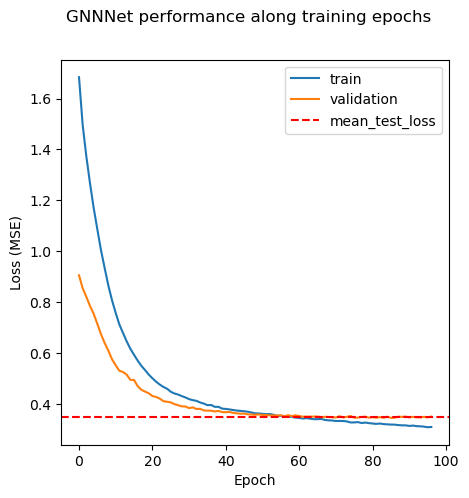

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(train_losses, label="train")
ax.plot(valid_losses, label="validation")
ax.axline((0,mean_test_loss.item()), slope=0, label="mean_test_loss", color="red", linestyle="--")
ax.legend()
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss (MSE)")
fig.suptitle("GNNNet performance along training epochs")

In [14]:
cat_test_targets = torch.concat(test_targets, dim=0)
cat_test_predictions = torch.concat(test_predictions, dim=0)

In [15]:
preds = test_predictions[0].detach().cpu()
targets = test_targets[0].detach().cpu()
preds = cat_test_predictions.detach().cpu()
targets = cat_test_targets.detach().cpu()

Text(0.02, 0.5, 'Prediction')

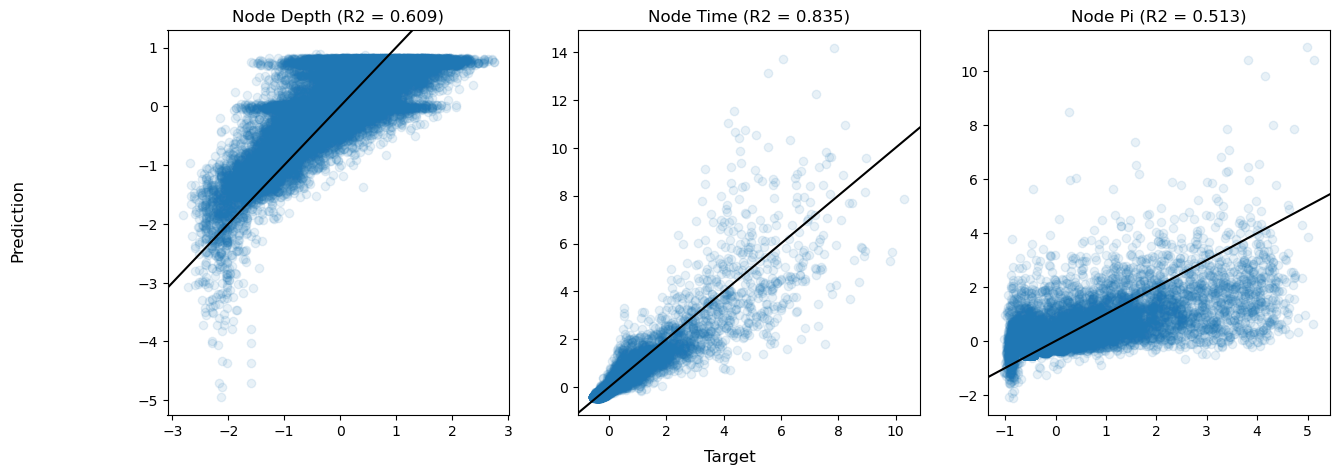

In [16]:
fig, axs = plt.subplots(1, len(stat_names), figsize=(15, 5))
for i, ax in enumerate(axs):
    ax.plot(targets[:,i], preds[:,i], 'o', alpha=0.1)
    ax.axline([0,0], [1,1], color='k')
    ax.set_title(f'{stat_names[i]} (R2 = {r2_score(targets[:,i], preds[:,i]):.3f})')
fig.supxlabel('Target')
fig.supylabel('Prediction')